In [22]:
# import packages
import os
from glob import glob
import pickle
from tqdm.notebook import tqdm
import random
from tabulate import tabulate

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
import torchvision.transforms.v2 as t

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam
from torchvision import models
from torchvision.transforms.v2 import (Resize, Compose, RandomHorizontalFlip, 
                                       ColorJitter, RandomAffine, RandomErasing, ToTensor)



In [ ]:
train = pd.read_csv(f"/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv")
print(train.shape)
train.head()

(3147, 15)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [ ]:
len(train.patient_id.unique())
# => 3147 patients

3147

In [ ]:
train_series_meta = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv")
print(train_series_meta.shape)
train_series_meta.head()

(4711, 4)


,patient_id,series_id,aortic_hu,incomplete_organ
0,10004,21057,146.00,0
1,10004,51033,454.75,0
2,10005,18667,187.00,0
3,10007,47578,329.00,0
4,10026,29700,327.00,0


In [ ]:
len(train_series_meta.series_id.unique())
# => 4711 - 3147 = 1564 patients take two CT series scans

4711

In [ ]:
sample_submission = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/sample_submission.csv")
print(sample_submission.shape)
sample_submission.head()

(3, 14)


,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,48843,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
1,50046,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
2,63706,0.5,0.5,0.5,0.5,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [ ]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patient_id             3 non-null      int64  
 1   bowel_healthy          3 non-null      float64
 2   bowel_injury           3 non-null      float64
 3   extravasation_healthy  3 non-null      float64
 4   extravasation_injury   3 non-null      float64
 5   kidney_healthy         3 non-null      float64
 6   kidney_low             3 non-null      float64
 7   kidney_high            3 non-null      float64
 8   liver_healthy          3 non-null      float64
 9   liver_low              3 non-null      float64
 10  liver_high             3 non-null      float64
 11  spleen_healthy         3 non-null      float64
 12  spleen_low             3 non-null      float64
 13  spleen_high            3 non-null      float64
dtypes: float64(13), int64(1)
memory usage: 464.0 bytes


In [ ]:
image_level_labels = pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
print(image_level_labels.shape)
image_level_labels.head()
# => 12029 images 

(12029, 4)


,patient_id,series_id,instance_number,injury_name
0,10004,21057,362,Active_Extravasation
1,10004,21057,363,Active_Extravasation
2,10004,21057,364,Active_Extravasation
3,10004,21057,365,Active_Extravasation
4,10004,21057,366,Active_Extravasation


In [ ]:
image_level_labels.injury_name.value_counts()

injury_name
Active_Extravasation    6370
Bowel                   5659
Name: count, dtype: int64

In [ ]:
image_level_labels.patient_id.value_counts()
# => num of images of extravasation or bowel injury per patient ranges from 1 to 410

patient_id
46022    410
19742    371
53581    350
11925    337
63113    282
        ... 
19249      1
36686      1
61530      1
14018      1
1675       1
Name: count, Length: 246, dtype: int64

<Axes: >

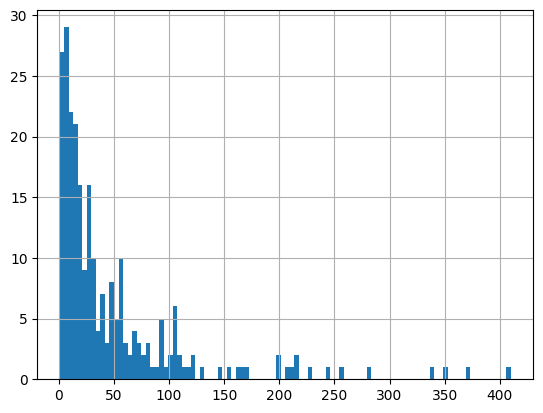

In [ ]:
image_level_labels.patient_id.value_counts().hist(bins=100)
# xlabel="# images", ylabel="# patients"

In [ ]:
len(image_level_labels.instance_number.unique())

925

In [ ]:
image_level_labels['image_id'] = image_level_labels['patient_id'].astype(str) + '_' + \
                                 image_level_labels['series_id'].astype(str) + '_' + \
                                 image_level_labels['instance_number'].astype(str)

In [ ]:
image_level_labels['image_id'].head()

0    10004_21057_362
1    10004_21057_363
2    10004_21057_364
3    10004_21057_365
4    10004_21057_366
Name: image_id, dtype: object

In [ ]:
len(image_level_labels.image_id.unique())

11536

In [ ]:
duplicated_values = image_level_labels[image_level_labels['image_id'].duplicated(keep=False)]['image_id'].unique()
print(len(duplicated_values))
# print(duplicated_values)

493


In [ ]:
image_level_labels[image_level_labels['image_id'] == '11925_60003_469']
# => Both bowel and extravasation injuries can be on the same image. 

,patient_id,series_id,instance_number,injury_name,image_id
766,11925,60003,469,Bowel,11925_60003_469
767,11925,60003,469,Active_Extravasation,11925_60003_469


In [ ]:
# def count_files_in_directory(directory):
#     file_count = 0
#     for root, dirs, files in os.walk(directory):
#         file_count += len(files)
#     return file_count

# directory_to_check = '/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations'  # ここに調査するディレクトリのパスを指定してください。
# print(f"There are {count_files_in_directory(directory_to_check)} files in {directory_to_check}.")
# # => segmentations: 206 files

In [ ]:
# def count_files_in_directory(directory):
#     file_count = 0
#     for root, dirs, files in tqdm(os.walk(directory)):
#         file_count += len(files)
# #         print(f"Processed {len(files)} files in {root}. Total so far: {file_count} files.")

#     return file_count

# directory_to_check = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'  # ここに調査するディレクトリのパスを指定してください。
# print(f"There are {count_files_in_directory(directory_to_check)} files in {directory_to_check}.")
# # => train images: 1500653 files

In [ ]:
# def count_files_in_directory(directory):
#     file_count = 0
#     for root, dirs, files in tqdm(os.walk(directory)):
#         file_count += len(files)
# #         print(f"Processed {len(files)} files in {root}. Total so far: {file_count} files.")

#     return file_count

# directory_to_check = '/kaggle/input/rsna-2023-abdominal-trauma-detection/test_images'  # ここに調査するディレクトリのパスを指定してください。
# print(f"There are {count_files_in_directory(directory_to_check)} files in {directory_to_check}.")
# # => test images: 3 files

In [ ]:
# def count_files_in_directory(directory):
#     file_count = 0
#     for root, dirs, files in tqdm(os.walk(directory)):
#         file_count += len(files)
# #         print(f"Processed {len(files)} files in {root}. Total so far: {file_count} files.")

#     return file_count

# directory_to_check = '/kaggle/input/rsna-2023-abdominal-trauma-detection/segmentations'  # ここに調査するディレクトリのパスを指定してください。
# print(f"There are {count_files_in_directory(directory_to_check)} files in {directory_to_check}.")
# # => segmentations: 206 files

In [ ]:
# def count_files_in_directory(directory):
#     file_count = 0
#     for root, dirs, files in tqdm(os.walk(directory)):
#         file_count += len(files)
# #         print(f"Processed {len(files)} files in {root}. Total so far: {file_count} files.")

#     return file_count

# directory_to_check = '/kaggle/input/rsna-2023-atd-reduced-256-5mm'  # ここに調査するディレクトリのパスを指定してください。
# print(f"There are {count_files_in_directory(directory_to_check)} files in {directory_to_check}.")
# # => segmentations: 487197 files

In [ ]:
num_images_per_series = []

directory = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train_images'  # ここに調査するディレクトリのパスを指定してください。

for patient in tqdm(os.listdir(directory)):
    for series in os.listdir(os.path.join(directory, patient)):
        num_images_per_series.append(len(os.listdir(os.path.join(directory, patient, series))))
        



 17%|█▋        | 537/3147 [00:08<01:25, 30.50it/s] 

In [ ]:
plt.hist(num_images_per_series, bins=100)

In [ ]:
min(num_images_per_series), max(num_images_per_series)
# num images per series ranges from 41 to 1727

In [20]:
BASE_PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection/'
TRAIN_IMG_PATH = '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1'
TRAIN_DF_PATH = '/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv'

In [4]:
d = os.listdir(TRAIN_IMG_PATH)
len(d)
# 193065

193065

In [5]:
import os
from collections import defaultdict

directory_path = TRAIN_IMG_PATH

patients_dict = defaultdict(lambda: defaultdict(int))
patients_to_series_to_img_file_list = defaultdict(lambda: defaultdict(list))
for filename in os.listdir(directory_path):
    if filename.endswith('.png'):
        patient_id, series_id, img_id = filename.split('_')
        patients_dict[patient_id][series_id] += 1
        patients_to_series_to_img_file_list[patient_id][series_id].append(filename)

num_patients = len(patients_dict)
num_series_per_patient = {k: len(v) for k, v in patients_dict.items()}
num_imgs_per_series_per_patient = {k: sum(v.values()) / len(v) for k, v in patients_dict.items()}

num_imgs_series = []
for patient, series_dict in patients_dict.items():
    num_imgs_series.extend(series_dict.values())

print(f'Number of patients: {num_patients}')
print(f'Average number of series per patient: {sum(num_series_per_patient.values()) / num_patients:.2f}')
print(f'Average number of images per series per patient: {sum(num_imgs_per_series_per_patient.values()) / num_patients:.2f}')


Number of patients: 400
Average number of series per patient: 1.48
Average number of images per series per patient: 353.94


(array([ 6.,  8.,  9.,  9., 26., 29., 29., 17., 13.,  8., 14., 22., 41.,
        21., 24., 15., 16., 13., 13.,  8.,  8.,  7.,  5.,  4., 10.,  4.,
         2.,  1.,  7.,  2.,  2.,  3.,  2.,  3.,  4.,  3.,  1.,  2.,  2.,
         5.,  2.,  1.,  0.,  3.,  3.,  1.,  2.,  0.,  1.,  2.,  6.,  2.,
         2.,  4.,  3.,  2.,  5.,  5.,  3.,  3.,  6.,  6.,  4.,  5.,  8.,
        11.,  6.,  5.,  5.,  8.,  0., 10.,  5.,  6.,  1.,  5.,  5.,  4.,
         2.,  2.,  3.,  1.,  2.,  2.,  0.,  2.,  1.,  0.,  1.,  1.,  1.,
         1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  2.]),
 array([  51.  ,   60.49,   69.98,   79.47,   88.96,   98.45,  107.94,
         117.43,  126.92,  136.41,  145.9 ,  155.39,  164.88,  174.37,
         183.86,  193.35,  202.84,  212.33,  221.82,  231.31,  240.8 ,
         250.29,  259.78,  269.27,  278.76,  288.25,  297.74,  307.23,
         316.72,  326.21,  335.7 ,  345.19,  354.68,  364.17,  373.66,
         383.15,  392.64,  402.13,  411.62,  421.11,  430.6 ,  440.09,
        

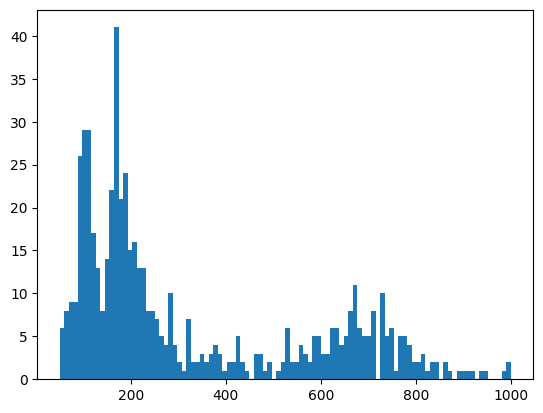

In [6]:
plt.hist(num_imgs_series, bins=100)

In [7]:
min(num_imgs_series), max(num_imgs_series)

(51, 1000)

In [8]:
len(patients_to_series_to_img_file_list)

400

In [9]:
def fetch_series_paths(img_dir):
    '''
    return a list of series that has img list
    ex) [[img, img, ..., img], [img, img, ..., img], ...]
    '''
    series_paths = []    
    patients_to_series_to_img_file_list = defaultdict(lambda: defaultdict(list))
    for filename in os.listdir(img_dir):
        if filename.endswith('.png'):
            patient_id, series_id, img_id = filename.split('_')
            patients_to_series_to_img_file_list[patient_id][series_id].append(os.path.join(img_dir, filename))
    
    for patient_id, series_to_img_file_list in patients_to_series_to_img_file_list.items():
        for series_id, img_file_list in series_to_img_file_list.items():
            series_paths.append(img_file_list)
            
    return series_paths
    

In [10]:
s_p = fetch_series_paths(TRAIN_IMG_PATH)
print(len(s_p))
s_p[3][:10]

592


['/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0264.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0517.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0073.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0382.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0345.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0577.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0412.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0017.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0536.png',
 '/kaggle/input/rsna-abdominal-trauma-detection-png-pt1/28990_54146_0151.png']

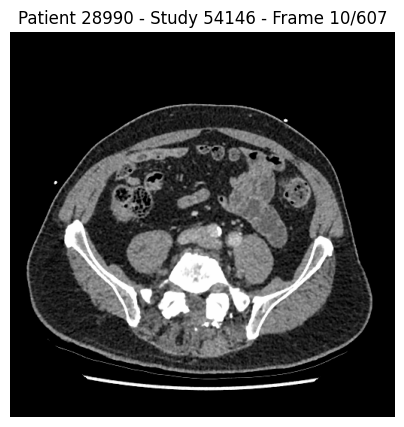

In [11]:
idx = 10
series = s_p[3]
img = cv2.imread(series[idx]) 
patient, study, img_id = os.path.basename(series[idx]).split('.')[0].split('_')

plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title(f"Patient {patient} - Study {study} - Frame {idx}/{len(series)}")
plt.axis(False)
plt.show()


In [12]:
img.shape, type(img)

((512, 512, 3), numpy.ndarray)

In [13]:
greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
greyscale.shape

(512, 512)

In [14]:
greyscale[200:300]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

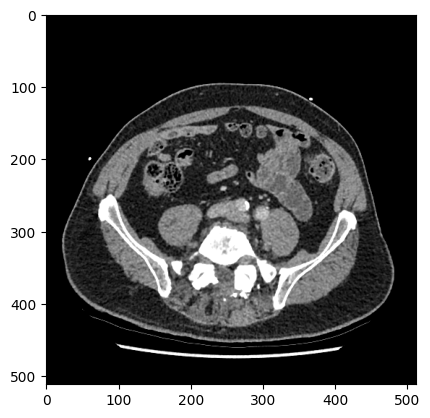

In [15]:
plt.imshow(greyscale / 255, cmap='gray')


In [18]:
test_series_meta = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/test_series_meta.csv')
print(test_series_meta.shape)
test_series_meta

(6, 3)


,patient_id,series_id,aortic_hu
0,48843,295,401.25
1,48843,62825,238.00
2,50046,24574,149.00
3,50046,60658,352.00
4,63706,39279,219.00
5,63706,41385,319.00


In [19]:
print(test_series_meta.shape)
unique_patients = test_series_meta['patient_id'].nunique()

(6, 3)


In [24]:
test_series_meta['dicom_folder'] = BASE_PATH + '/' + 'test_images' \
                                    + '/' + test_series_meta.patient_id.astype(str) \
                                    + '/' + test_series_meta.series_id.astype(str)
STRIDE = 10

test_folders = test_series_meta.dicom_folder.tolist()
test_paths = []
for folder in tqdm(test_folders):
    test_paths += sorted(glob(os.path.join(folder, "*.dcm")))[::STRIDE]
    

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
IMAGE_DIR = './test_data_preprocessed_v2'

test_df = pd.DataFrame(test_paths, columns=['dicom_path'])
test_df['patient_id'] = test_df.dicom_path.map(lambda x: x.split('/')[-3]).astype(int)
test_df['series_id'] = test_df.dicom_path.map(lambda x: x.split('/')[-2]).astype(int)
test_df['instance_number'] = test_df.dicom_path.map(lambda x: x.split('/')[-1].replace('.dcm','')).astype(int)

test_df['image_path'] = f'{IMAGE_DIR}'\
                    + '/' + test_df.patient_id.astype(str)\
                    + '/' + test_df.series_id.astype(str)\
                    + '/' + test_df.instance_number.astype(str) +'.png'

test_df.head(2)